In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import multivariate_normal as norm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def create_complete_datasets(data_dict):
    '''
    Function for creating complete training and test sets containing
    all classes.
    '''
    #Empty list
    trainset = []
    traintargets =[]
    testset = []
    testtargets =[]
    
    #For each class
    for i in range(10):
        trainset.append(data_dict["train%d"%i])
        traintargets.append(np.full(len(data_dict["train%d"%i]),i))
        testset.append(data_dict["test%d"%i])
        testtargets.append(np.full(len(data_dict["test%d"%i]),i))
    
    #Concatenate into to complete datasets
    trainset = np.concatenate(trainset)
    traintargets = np.concatenate(traintargets)
    testset = np.concatenate(testset)
    testtargets = np.concatenate(testtargets)
    return trainset, traintargets, testset, testtargets

file = "mnist_all.mat"
data = loadmat(file)

#Complete training and test sets
train_set, train_targets, test_set, test_targets = create_complete_datasets(data)

In [3]:
n_comp = 9

#PCA

def PCA_function(train_set,train_targets, value, pca):
    train_pca = np.asarray([train_set[i] for i in range(len(train_targets)) if train_targets[i] == value])
    transformed = pca.transform(train_pca)
    return transformed

pca = PCA(n_components=9)
pca.fit(train_set)

train_set_pca = [PCA_function(train_set, train_targets, i, pca) for i in range(10)]
train_set_pca = np.asarray(train_set_pca, dtype=object)



#LDA

def LDA_function(train_set, train_targets, value, lda):
    train_lda = np.asarray([train_set[i] for i in range(len(train_targets)) if train_targets[i] == value])
    transformed = lda.transform(train_lda)
    return transformed


lda = LDA(n_components=9)
lda.fit(train_set,train_targets)

train_set_lda = [LDA_function(train_set, train_targets, i, lda) for i in range(10)]
train_set_lda = np.asarray(train_set_lda, dtype=object)




In [4]:
def getMean(train_set):
    mean = []
    for i in range(10):
        mean.append(np.mean(train_set[i],axis=0))
    return mean

def getCov(train_set):
    cov = []
    for i in range(10):
        cov.append(np.cov(train_set[i],rowvar=False))
    return cov

def getPriors(train_targets):
    priors = []
    for i in range(10):
        priors.append((train_targets==i).sum()/len(train_targets))
    return priors

priors = getPriors(train_targets)

pca_means = getMean(train_set_pca)
pca_covs = getCov(train_set_pca)

lda_means = getMean(train_set_lda)
lda_covs = getCov(train_set_lda)



In [5]:
# Analyze proportion of Variance. If num_components=2 try to visualize dim. reduced data.



In [6]:
# Estimate Gaussians from PCA/LDA

In [7]:
#Compute predictions
test_set_pca = pca.transform(test_set)
test_set_lda = lda.transform(test_set)

def getPredictions(test_data, mean, cov, priors):
    likelihood = [norm.pdf(test_data, mean[i], cov[i]) for i in range(10)]
    posteriors = [likelihood[i]*priors[i] for i in range(10)]
    predictions = np.argmax(posteriors, axis=0)
    return predictions

predictions_pca = getPredictions(test_set_pca, pca_means, pca_covs, priors)
predictions_lda = getPredictions(test_set_lda, lda_means, lda_covs, priors)


#Compute accuracy
accuracy_pca = (np.where(predictions_pca == test_targets, 1, 0).sum()/len(test_targets))* 100
accuracy_lda = (np.where(predictions_lda == test_targets,1,0).sum()/len(test_targets))* 100

print("PCA accuracy: ", accuracy_pca)
print("LDA accuracy: ", accuracy_lda)


PCA accuracy:  87.76
LDA accuracy:  89.53


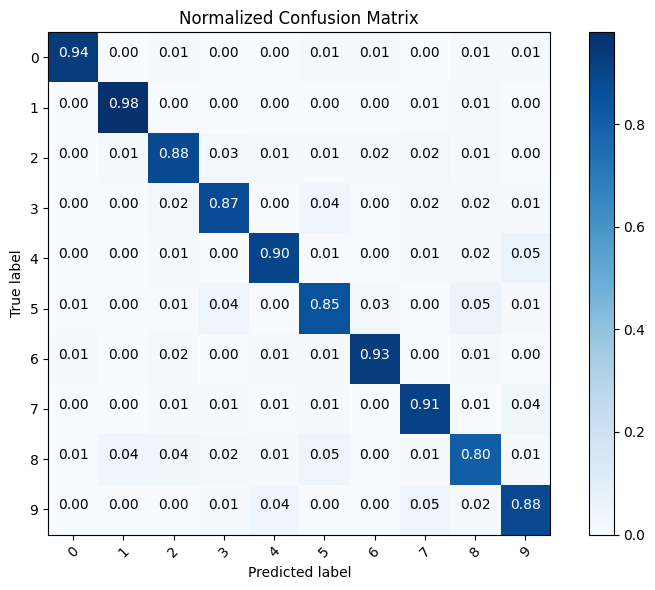

In [11]:
#Compute the confusion matrices for PCA and LDA

pca_confusion = np.zeros((10,10))
lda_confusion = np.zeros((10,10))

for i in range(len(predictions_pca)):
    pca_confusion[predictions_pca[i]][test_targets[i]] += 1

for i in range(len(predictions_lda)):
    lda_confusion[predictions_lda[i]][test_targets[i]] += 1
    

#Plot Confusion matrices

import itertools

def plot_confusion_matrix(confusion_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))

    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        plt.title('Normalized ' + title)
    else:
        plt.title(title)

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.

    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class_names = ['0','1','2','3','4','5','6','7','8','9']  # Replace with your class names
plot_confusion_matrix(lda_confusion, classes=class_names, normalize=True)  # Set normalize=False for non-normalized matrix
plt.show()
